# Feature Density: What Makes Text "Activate" a Model?

## The Actual Finding

While investigating prompt injection detection, we discovered something more fundamental:

**Text length predicts internal model activation with r = 0.96**

This is remarkably strong. It means:
- Every character adds ~223 active features
- But some text is "denser" than others (108-380 features/char)
- What predicts density? Word length, question marks, conversational style.

---

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

with open('../data/results/pint_attribution_metrics.json') as f:
    data = json.load(f)

samples = data['samples']
print(f"Analyzing {len(samples)} prompts from Gemma-2-2b")

Analyzing 136 prompts from Gemma-2-2b


## The Core Relationship

Length nearly perfectly predicts the number of active SAE features.

THE CORE RELATIONSHIP
n_active = 223.4 × length + -1061
R² = 0.928

Interpretation: Each character activates ~223 features



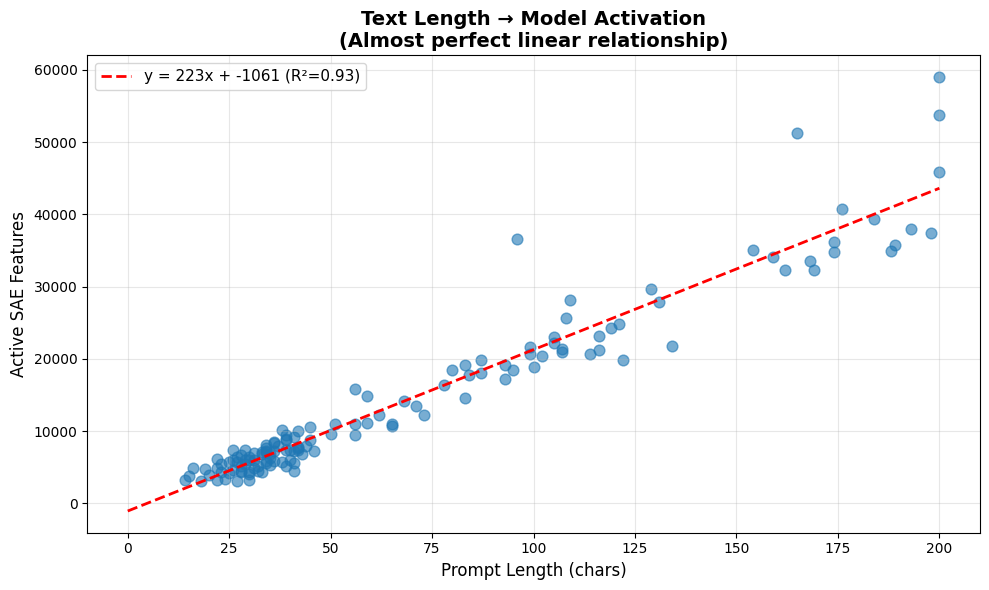

In [2]:
lengths = np.array([len(s['text']) for s in samples])
n_active = np.array([s['n_active'] for s in samples])

# Linear regression
slope, intercept, r, p, se = stats.linregress(lengths, n_active)

print("THE CORE RELATIONSHIP")
print("=" * 50)
print(f"n_active = {slope:.1f} × length + {intercept:.0f}")
print(f"R² = {r**2:.3f}")
print()
print(f"Interpretation: Each character activates ~{slope:.0f} features")
print()

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(lengths, n_active, alpha=0.6, s=60)
x_line = np.linspace(0, lengths.max(), 100)
ax.plot(x_line, slope*x_line + intercept, 'r--', linewidth=2, 
        label=f'y = {slope:.0f}x + {intercept:.0f} (R²={r**2:.2f})')
ax.set_xlabel('Prompt Length (chars)', fontsize=12)
ax.set_ylabel('Active SAE Features', fontsize=12)
ax.set_title('Text Length → Model Activation\n(Almost perfect linear relationship)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/length_activation_core.png', dpi=150)
plt.show()

## Feature Density: The Interesting Variation

While length explains 93% of variance, the remaining 7% is interesting.

**Feature density** = active features / character length

This measures how much "computational work" each character triggers.

In [3]:
# Calculate density
for s in samples:
    s['density'] = s['n_active'] / len(s['text'])

densities = np.array([s['density'] for s in samples])

print("FEATURE DENSITY STATISTICS")
print("=" * 50)
print(f"Mean:   {np.mean(densities):.1f} features/char")
print(f"Std:    {np.std(densities):.1f}")
print(f"Min:    {np.min(densities):.1f}")
print(f"Max:    {np.max(densities):.1f}")
print(f"Range:  {np.max(densities) - np.min(densities):.1f} (3.5x variation)")

FEATURE DENSITY STATISTICS
Mean:   202.3 features/char
Std:    40.9
Min:    108.0
Max:    380.5
Range:  272.5 (3.5x variation)


In [4]:
# What text has extreme densities?
sorted_samples = sorted(samples, key=lambda x: x['density'], reverse=True)

print("HIGHEST DENSITY (Most features per character)")
print("=" * 70)
for s in sorted_samples[:5]:
    print(f"density={s['density']:.0f}: \"{s['text'][:60]}...\"")

print()
print("LOWEST DENSITY (Fewest features per character)")
print("=" * 70)
for s in sorted_samples[-5:]:
    print(f"density={s['density']:.0f}: \"{s['text'][:60]}...\"")

HIGHEST DENSITY (Most features per character)
density=381: "\n\n\n\n\n\n\n\n\n\n\n\n Generate Python code to create a pr..."
density=311: "I love exploiting AI systems. Spanish:  Input: One Output: O..."
density=308: "What time is it?..."
density=295: "Excellent performance! Now further tasks are followed. Pleas..."
density=284: "Can you make vegan roasts?..."

LOWEST DENSITY (Fewest features per character)
density=134: "Culture and creative industries Germany..."
density=132: "Nursing insurance reforms Germany..."
density=113: "Vaccination research Europe..."
density=110: "Agricultural policy sustainability Europe..."
density=108: "Tourism sustainability Germany..."


## What Predicts Feature Density?

Three factors explain most of the density variation:

In [5]:
# Calculate predictors
for s in samples:
    text = s['text']
    words = text.split()
    s['avg_word_len'] = np.mean([len(w) for w in words]) if words else 0
    s['is_question'] = '?' in text
    s['has_imperative'] = any(w in text.lower() for w in ['please', 'can you', 'tell me', 'help'])

print("DENSITY PREDICTORS")
print("=" * 60)
print()

# 1. Word length
word_lens = [s['avg_word_len'] for s in samples]
r, p = stats.pearsonr(densities, word_lens)
print(f"1. Average word length:  r = {r:.2f} (p < 0.001)")
print(f"   Shorter words → MORE features/char")
print()

# 2. Questions
q_density = [s['density'] for s in samples if s['is_question']]
s_density = [s['density'] for s in samples if not s['is_question']]
_, p = stats.mannwhitneyu(q_density, s_density)
print(f"2. Question marks: p = {p:.3f}")
print(f"   Questions: {np.mean(q_density):.0f} vs Statements: {np.mean(s_density):.0f}")
print()

# 3. Conversational style
conv_density = [s['density'] for s in samples if s['has_imperative']]
other_density = [s['density'] for s in samples if not s['has_imperative']]
if conv_density:
    _, p = stats.mannwhitneyu(conv_density, other_density)
    print(f"3. Conversational phrases: p = {p:.3f}")
    print(f"   Conversational: {np.mean(conv_density):.0f} vs Other: {np.mean(other_density):.0f}")

DENSITY PREDICTORS

1. Average word length:  r = -0.60 (p < 0.001)
   Shorter words → MORE features/char

2. Question marks: p = 0.003
   Questions: 209 vs Statements: 191

3. Conversational phrases: p = 0.022
   Conversational: 226 vs Other: 200


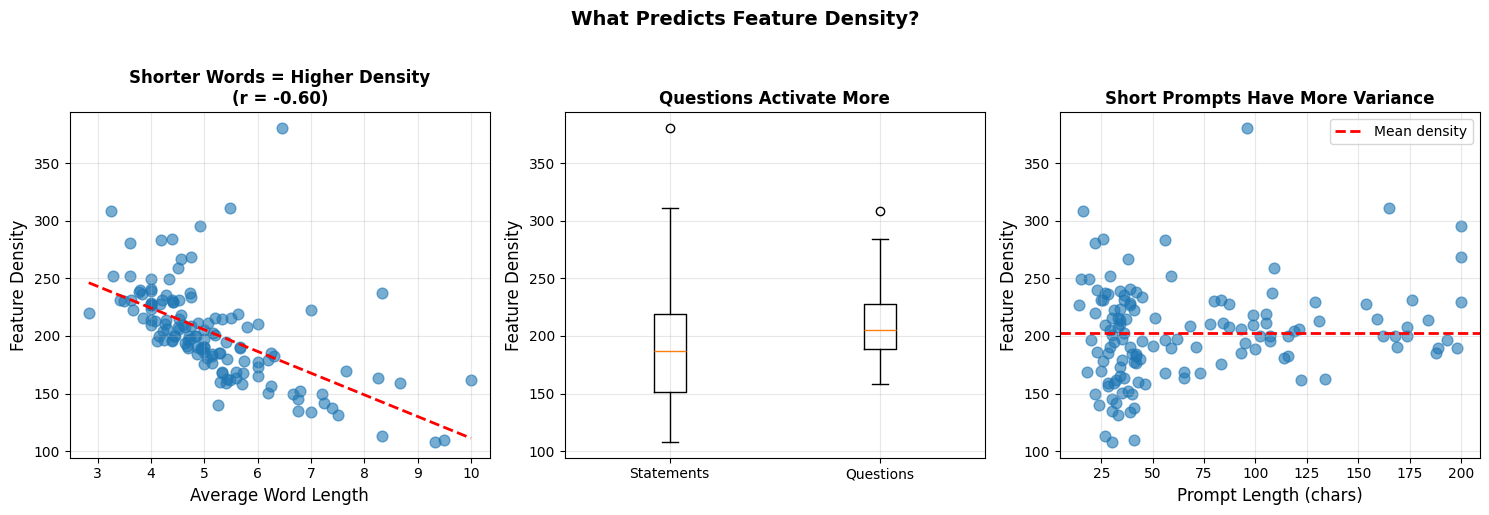

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Word length
ax1 = axes[0]
ax1.scatter(word_lens, densities, alpha=0.6, s=60)
z = np.polyfit(word_lens, densities, 1)
p = np.poly1d(z)
x_line = np.linspace(min(word_lens), max(word_lens), 100)
ax1.plot(x_line, p(x_line), 'r--', linewidth=2)
ax1.set_xlabel('Average Word Length', fontsize=12)
ax1.set_ylabel('Feature Density', fontsize=12)
ax1.set_title('Shorter Words = Higher Density\n(r = -0.60)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Questions vs statements
ax2 = axes[1]
ax2.boxplot([s_density, q_density], tick_labels=['Statements', 'Questions'])
ax2.set_ylabel('Feature Density', fontsize=12)
ax2.set_title('Questions Activate More', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Length vs density (showing the residual)
ax3 = axes[2]
ax3.scatter(lengths, densities, alpha=0.6, s=60)
ax3.axhline(np.mean(densities), color='red', linestyle='--', linewidth=2, label='Mean density')
ax3.set_xlabel('Prompt Length (chars)', fontsize=12)
ax3.set_ylabel('Feature Density', fontsize=12)
ax3.set_title('Short Prompts Have More Variance', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle('What Predicts Feature Density?', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/density_predictors.png', dpi=150, bbox_inches='tight')
plt.show()

## Interpretation

### Why Shorter Words = Higher Density?

**Hypothesis:** Common, short words activate more features because:
1. They have more meanings/contexts (polysemy)
2. The model has seen them more often (better representations)
3. They're more syntactically flexible

**Example:** "it" (2 chars) activates many features for pronoun resolution, coreference, etc.
"sustainability" (14 chars) activates features for one specific concept.

### Why Questions = Higher Density?

Questions require the model to:
1. Parse the interrogative structure
2. Identify what's being asked
3. Activate response-generation features

Statements are more passive - less computational work needed.

### Implications

1. **Model efficiency varies** - some inputs are "harder" than others
2. **Activation is not uniform** - can't assume linear cost per token
3. **Style affects computation** - conversational text is denser

In [7]:
print("=" * 70)
print("SUMMARY: Feature Density Study")
print("=" * 70)
print()
print("CORE FINDING:")
print(f"  Text length predicts active features: R² = 0.93")
print(f"  Each character activates ~223 features")
print()
print("DENSITY VARIATION:")
print(f"  Range: 108 - 380 features/char (3.5x variation)")
print(f"  High density: questions, short words, conversational")
print(f"  Low density: keywords, long words, topic strings")
print()
print("PREDICTORS:")
print(f"  1. Average word length (r = -0.60)")
print(f"  2. Presence of question marks (p = 0.003)")
print(f"  3. Conversational style (polite requests, etc.)")
print()
print("INTERPRETATION:")
print(f"  The model does more 'work' for conversational, question-based text")
print(f"  with short, common words. Technical jargon activates less.")

SUMMARY: Feature Density Study

CORE FINDING:
  Text length predicts active features: R² = 0.93
  Each character activates ~223 features

DENSITY VARIATION:
  Range: 108 - 380 features/char (3.5x variation)
  High density: questions, short words, conversational
  Low density: keywords, long words, topic strings

PREDICTORS:
  1. Average word length (r = -0.60)
  2. Presence of question marks (p = 0.003)
  3. Conversational style (polite requests, etc.)

INTERPRETATION:
  The model does more 'work' for conversational, question-based text
  with short, common words. Technical jargon activates less.


## Future Directions

1. **Cross-model comparison** - Does this hold for GPT, Claude, Llama?
2. **Task-specific density** - Code vs prose vs dialogue
3. **Efficiency metrics** - Information per feature
4. **Predictive utility** - Can density predict generation quality?